### File 2:
Target:
* Add BatchNorm to increase model efficiency.
 
Results:
* Parameters: 9.3k
* Training Accuracy: 99.38
* Testing Accuracy: 99.04

Best Testing Accuracy: 99.16 (13th epoch)

Analysis:
* Model started overfitting now (0.38 diff). 
* Better accuracy but may need to add more capacity, especially at the end. Since we know that mnist can be stopped at an RF of 5*5.











## Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

## Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


## Dataloader Arguments & Test/Train Dataloaders

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## Data Statistics



[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0002)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


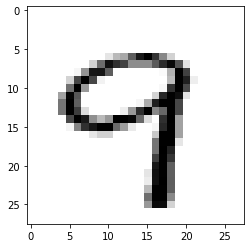

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.data.cpu().numpy().shape)
print(' - Tensor Shape:', train.data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

## Data Visualization

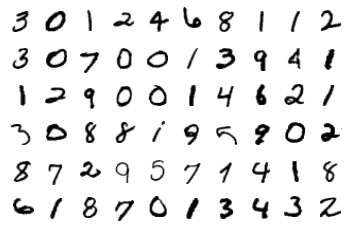

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## The Model 

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
      
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=14, kernel_size=(3,3), padding=0, bias=False),
            nn.BatchNorm2d(14),
            nn.ReLU()
        ) # output = 26*26*14

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3,3), padding=0, bias=False),
            nn.BatchNorm2d(14),
            nn.ReLU()
        ) # output = 24*24*14

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=20, kernel_size=(3,3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output = 22*22*20

        self.pool1 = nn.MaxPool2d(2, 2) # output = 11*11*20

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=14, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(14),
            nn.ReLU()
        ) # output = 11*11*14

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(14),
            nn.ReLU()
        ) # output = 9*9*14

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output = 7*7*20

        self.gap = nn.Sequential(nn.AdaptiveAvgPool2d(1)) # output = 1*1*20
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels = 20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False) 
        ) # output = 1*1*10
        
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = self.convblock7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model Params

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 14, 26, 26]             126
       BatchNorm2d-2           [-1, 14, 26, 26]              28
              ReLU-3           [-1, 14, 26, 26]               0
            Conv2d-4           [-1, 14, 24, 24]           1,764
       BatchNorm2d-5           [-1, 14, 24, 24]              28
              ReLU-6           [-1, 14, 24, 24]               0
            Conv2d-7           [-1, 20, 22, 22]           2,520
       BatchNorm2d-8           [-1, 20, 22, 22]              40
              ReLU-9           [-1, 20, 22, 22]               0
        MaxPool2d-10           [-1, 20, 11, 11]               0
           Conv2d-11           [-1, 14, 11, 11]             280
      BatchNorm2d-12           [-1, 14, 11, 11]              28
             ReLU-13           [-1, 14, 11, 11]               0
           Conv2d-14             [-1, 1

## Training and Testing

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Training and Testing the Model

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.18159739673137665 Batch_id=468 Accuracy=81.11: 100%|██████████| 469/469 [00:17<00:00, 26.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1689, Accuracy: 9598/10000 (95.98%)

EPOCH: 1


Loss=0.09049010276794434 Batch_id=468 Accuracy=97.22: 100%|██████████| 469/469 [00:18<00:00, 26.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0928, Accuracy: 9765/10000 (97.65%)

EPOCH: 2


Loss=0.06508535891771317 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:18<00:00, 25.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0684, Accuracy: 9827/10000 (98.27%)

EPOCH: 3


Loss=0.1100631058216095 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:18<00:00, 25.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0621, Accuracy: 9822/10000 (98.22%)

EPOCH: 4


Loss=0.035017285495996475 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:18<00:00, 25.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0457, Accuracy: 9875/10000 (98.75%)

EPOCH: 5


Loss=0.03553282096982002 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:18<00:00, 26.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0397, Accuracy: 9886/10000 (98.86%)

EPOCH: 6


Loss=0.04568907245993614 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:18<00:00, 25.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Accuracy: 9874/10000 (98.74%)

EPOCH: 7


Loss=0.037600770592689514 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:17<00:00, 26.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Accuracy: 9890/10000 (98.90%)

EPOCH: 8


Loss=0.05705605819821358 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:18<00:00, 25.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0386, Accuracy: 9879/10000 (98.79%)

EPOCH: 9


Loss=0.010927523486316204 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:17<00:00, 26.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9905/10000 (99.05%)

EPOCH: 10


Loss=0.04036673903465271 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:18<00:00, 25.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 9885/10000 (98.85%)

EPOCH: 11


Loss=0.012231449596583843 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:18<00:00, 25.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9909/10000 (99.09%)

EPOCH: 12


Loss=0.008839164860546589 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:18<00:00, 25.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Accuracy: 9899/10000 (98.99%)

EPOCH: 13


Loss=0.008068581111729145 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:18<00:00, 26.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9916/10000 (99.16%)

EPOCH: 14


Loss=0.032831236720085144 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:18<00:00, 25.86it/s]



Test set: Average loss: 0.0288, Accuracy: 9904/10000 (99.04%)



## Loss and Accuracy

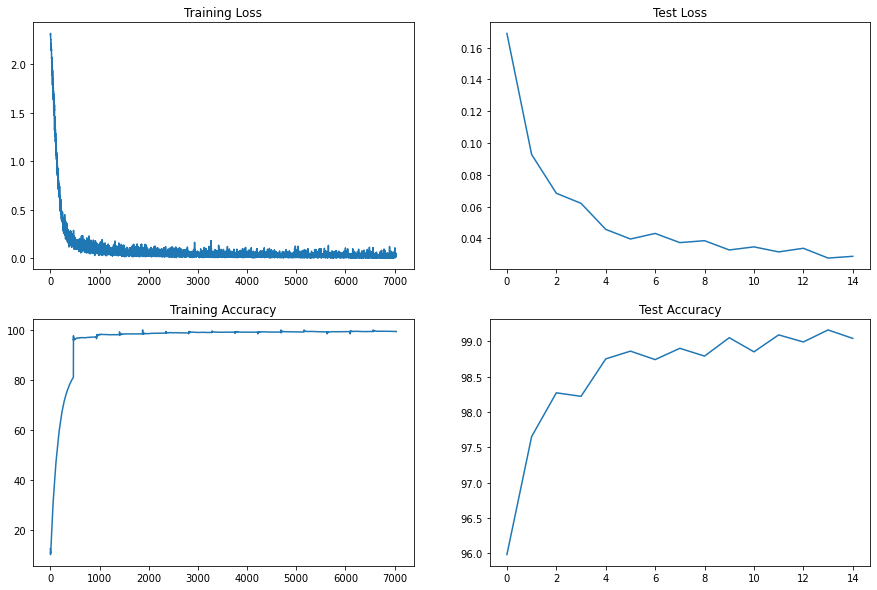

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy");

### That's all Folks!